# data 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

In [2]:
# file_path = "/content/현대자동차.csv"
# corps_name = file_path.split('/')[2].split('.')[0] # corps_name = "현대자동차" # 기업명 - 시각화 그래프에 사용

In [4]:
stock = pd.read_csv(file_path, index_col=0)
stock

,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
2021-06-30,239500,0,0.00,240000,241000,238500,653096,156348960372,51173530786500,213668187
2021-06-29,239500,-1500,-0.62,240500,242500,239000,627915,150635106000,51173530786500,213668187
2021-06-28,241000,-2000,-0.82,244000,244500,240000,575102,138789048000,51494033067000,213668187
2021-06-25,243000,500,0.21,243500,244000,241000,537893,130455190500,51921369441000,213668187
2021-06-24,242500,0,0.00,243500,249000,241000,1494131,365731706500,51814535347500,213668187
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,178000,8000,4.71,172500,178000,171000,902742,158423821252,39209213262000,220276479
2015-01-07,170000,5500,3.34,163000,171500,163000,511006,86384012000,37447001430000,220276479
2015-01-06,164500,-3500,-2.08,166500,167000,164000,635059,104856982500,36235480795500,220276479
2015-01-05,168000,-1000,-0.59,171000,171000,166000,454073,76211663500,37006448472000,220276479


# preprocessing

## 10일 간격의 데이터로 다음 날 주식 종가를 예측하기 위한 학습 데이터 생성

In [ ]:
periods = 10

X = []
y = []
for i in range(len(stock) - periods):
    end_idx = i + periods
    X.append(stock['종가'].iloc[i:end_idx].tolist())
    y.append(stock['종가'].iloc[end_idx].tolist())

data = pd.DataFrame(X)
data['target'] = y
data.columns = ['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10','target']

data = data.astype(int)

In [6]:
print(data.shape)
data

(1588, 11)


,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,target
0,239500,239500,241000,243000,242500,242500,241000,233000,235000,236500,239500
1,239500,241000,243000,242500,242500,241000,233000,235000,236500,239500,237000
2,241000,243000,242500,242500,241000,233000,235000,236500,239500,237000,238000
3,243000,242500,242500,241000,233000,235000,236500,239500,237000,238000,238500
4,242500,242500,241000,233000,235000,236500,239500,237000,238000,238500,236000
...,...,...,...,...,...,...,...,...,...,...,...
1583,168000,171500,173500,172500,171000,174500,177500,179500,177500,180000,178000
1584,171500,173500,172500,171000,174500,177500,179500,177500,180000,178000,170000
1585,173500,172500,171000,174500,177500,179500,177500,180000,178000,170000,164500
1586,172500,171000,174500,177500,179500,177500,180000,178000,170000,164500,168000


# Keras RNN

## 입력변수 & 목표변수

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scale = MinMaxScaler()

# 정규화 적용
X = scale.fit_transform(data.loc[:, data.columns != 'target'])
print(X.shape)
X = X[..., np.newaxis] # 차원 증가 (10, ) -> (10, 1)
print(X.shape)

y = data.loc[:, 'target']

(1588, 10)
(1588, 10, 1)


In [10]:
print(X[0].shape)
X[0], y[0]

(10, 1)


(array([[0.86111111],
        [0.86111111],
        [0.86855159],
        [0.87847222],
        [0.87599206],
        [0.87599206],
        [0.86855159],
        [0.82886905],
        [0.83878968],
        [0.84623016]]), 239500)

## 데이터 분할

In [11]:
from sklearn.model_selection import train_test_split

# train:test - 8:2 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train:val - 8:2 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Keras 모델 만들기

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [13]:
model = Sequential()
model.add(SimpleRNN(8, activation='relu', input_shape=(10,1)))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 80        
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 - 1s - loss: 22513999872.0000 - mse: 22513999872.0000 - val_loss: 21981161472.0000 - val_mse: 21981161472.0000
Epoch 2/100
32/32 - 0s - loss: 22513524736.0000 - mse: 22513524736.0000 - val_loss: 21980182528.0000 - val_mse: 21980182528.0000
Epoch 3/100
32/32 - 0s - loss: 22510188544.0000 - mse: 22510188544.0000 - val_loss: 21971007488.0000 - val_mse: 21971007488.0000
Epoch 4/100
32/32 - 0s - loss: 22467932160.0000 - mse: 22467932160.0000 - val_loss: 21853454336.0000 - val_mse: 21853454336.0000
Epoch 

## loss 변화 시각화

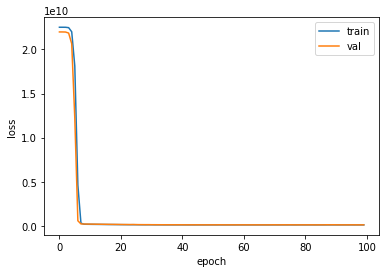

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

## 학습 & 테스트 결과

In [15]:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse.round(2)}")
print(f"Test RMSE: {test_rmse.round(2)}")

Train RMSE: 9859.8
Test RMSE: 8871.21


## test 예측 결과 시각화

In [16]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test.values)), y=y_test.values,
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test.values)), y=test_pred.ravel(),
                    line=dict(dash='dash', width=3),
                    name='pred'))

fig.update_layout(
    title=f"{corps_name} 종가 실제값-예측값",
    height=500)
fig.show()